In [97]:
# basic setup

import os
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt



df = pd.read_csv(os.path.expanduser('~/desktop/datainterview1/ws-data-spark-master/data/DataSample.csv'))
pols = pd.read_csv(os.path.expanduser('~/desktop/datainterview1/ws-data-spark-master/data/POIList.csv'))


In [98]:
# 1. Cleanup: delete data with identical TimeSt and geoinfo. 

In [99]:

filteredColumn = df.filter(['Country','Province','City','TimeSt','Latitude','Longitude'])
filteredColumn.drop_duplicates(inplace = True)
filteredColumn



,Country,Province,City,Latitude,Longitude
0,CA,ON,Waterloo,43.49347,-80.49123
1,CA,ON,London,42.93990,-81.27090
2,CA,ON,Guelph,43.57760,-80.22010
3,CA,ON,Stratford,43.37160,-80.97730
5,CA,ON,Kitchener,43.43810,-80.50990
...,...,...,...,...,...
21964,CA,NS,Antigonish,45.69906,-62.04134
21980,CA,ON,Burlington,43.37700,-79.80910
21981,CA,ON,Scarborough,43.80464,-79.32983
21983,CA,ON,Ottawa,45.42150,-75.65810


In [100]:
boolean = filteredColumn.duplicated()
boolean

0        False
1        False
2        False
3        False
5        False
         ...  
21964    False
21980    False
21981    False
21983    False
22012    False
Length: 5551, dtype: bool

In [101]:
df = df.iloc[boolean.index]
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990
...,...,...,...,...,...,...,...
21964,5612336,2017-06-21 14:22:50.413,CA,NS,Antigonish,45.69906,-62.04134
21980,5613100,2017-06-21 22:22:54.400,CA,ON,Burlington,43.37700,-79.80910
21981,5613184,2017-06-21 10:22:54.520,CA,ON,Scarborough,43.80464,-79.32983
21983,5613304,2017-06-21 08:22:52.710,CA,ON,Ottawa,45.42150,-75.65810


In [102]:
# 2. Label

In [103]:
# merge poi1 and poi2 since they have same lat and lon. 
pols.at[1,'POIID']='POI1/POI2'
pols = pols.drop(0)
pols

,POIID,Latitude,Longitude
1,POI1/POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [104]:
lat = df.Latitude
long = df.Longitude

In [105]:
# eliminate space for easier access
pols = pols.rename(columns={' Latitude': 'Latitude'})


In [106]:
# latitude and longitude for each POI
lat12 = pols[0:1].Latitude
lon12 = pols[0:1].Longitude
lat3 = pols[1:2].Latitude
lon3 = pols[1:2].Longitude
lat4 = pols[2:3].Latitude
lon4 = pols[2:3].Longitude

In [107]:
# calculate distance based on Harversine formula
def calculateDistance(origin, destination):
    lati1, long1 = origin
    lati2, long2 = destination
    radius = 6371  # km
    dlat = math.radians(lati2 - lati1)
    dlon = math.radians(long2 - long1)
    a = (math.sin(dlat / 2)**2 + math.cos(math.radians(lati1))*math.cos(math.radians(lati2))*
         math.sin(dlon / 2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d


In [108]:
def minDistance(latitude, longitude):
    dis12 = calculateDistance((lat12,lon12),(latitude,longitude))
    dis3 = calculateDistance((lat3,lon3),(latitude,longitude))
    dis4 = calculateDistance((lat4,lon4),(latitude,longitude))
    return min(dis12,dis3,dis4)

In [109]:

def labelRow(latitude, longitude):
    dis12 = calculateDistance((lat12,lon12),(latitude,longitude))
    dis3 = calculateDistance((lat3,lon3),(latitude,longitude))
    dis4 = calculateDistance((lat4,lon4),(latitude,longitude))
    Min = min(dis12,dis3,dis4)
    if (dis12 == Min): 
     return 'POI1/POI2'
    

    if (dis3 == Min): 
     return 'POI3'
    
    else: 
     return 'POI4'


In [110]:
# label each request and calculate distance to its label 
for index,row in df.iterrows():
    label = labelRow(row['Latitude'], row['Longitude'])
    distance = minDistance(row['Latitude'], row['Longitude'])
    df.loc[index,"label"] = label
    df.loc[index,"distance"] = distance

In [111]:
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,label,distance
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3,593.413441
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3,677.309655
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3,569.647737
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3,634.733996
5,4516693,2017-06-21 14:00:00.597,CA,ON,Kitchener,43.43810,-80.50990,POI3,597.378743
...,...,...,...,...,...,...,...,...,...
21964,5612336,2017-06-21 14:22:50.413,CA,NS,Antigonish,45.69906,-62.04134,POI4,106.835436
21980,5613100,2017-06-21 22:22:54.400,CA,ON,Burlington,43.37700,-79.80910,POI3,549.750275
21981,5613184,2017-06-21 10:22:54.520,CA,ON,Scarborough,43.80464,-79.32983,POI3,494.062855
21983,5613304,2017-06-21 08:22:52.710,CA,ON,Ottawa,45.42150,-75.65810,POI3,163.508432


In [112]:
# 3. Analysis 

In [113]:
# calculate average, sd, radius(maximum distance), density(count/area)
for index,row in pols.iterrows():
    pols.loc[index, "Average"] =  df[df.label == row["POIID"]]["distance"].mean() 
    pols.loc[index, "StandardDeviation"] = df[df.label == row["POIID"]]["distance"].std()
    pols.loc[index, "radius"] =df[df.label == row["POIID"]]["distance"].max() 
    pols.loc[index, "count"] =df[df.label == row["POIID"]]["distance"].count() 
    r = df[df.label == row["POIID"]]["distance"].max() 
    pols.loc[index, "density"] =df[df.label == row["POIID"]]["distance"].count()/(math.pi*(r**2))

In [114]:
pols

,POIID,Latitude,Longitude,Average,StandardDeviation,radius,count,density
1,POI1/POI2,53.546167,-113.485734,395.616984,560.907337,11531.820832,3043.0,7.283771e-06
2,POI3,45.521629,-73.566024,434.721966,233.673086,1474.580962,2289.0,3.350878e-04
3,POI4,45.224830,-63.232729,699.777511,1895.820743,9349.572770,219.0,7.974633e-07


In [115]:
# 4. Modelling

In [116]:
# 1a. outlier unremoved
# map each POI to a scale that ranges from -10 to 10
# we calulate it by (density - minDensity)/(maxDensity-minDensity)*20+(-10)

for index,row in pols.iterrows():
    pols.loc[index, "popularity"] =  ((row.density - pols.density.min())/(pols.density.max()-pols.density.min()))*20-10




In [117]:
pols


,POIID,Latitude,Longitude,Average,StandardDeviation,radius,count,density,popularity
1,POI1/POI2,53.546167,-113.485734,395.616984,560.907337,11531.820832,3043.0,7.283771e-06,-9.611936
2,POI3,45.521629,-73.566024,434.721966,233.673086,1474.580962,2289.0,3.350878e-04,10.000000
3,POI4,45.224830,-63.232729,699.777511,1895.820743,9349.572770,219.0,7.974633e-07,-10.000000


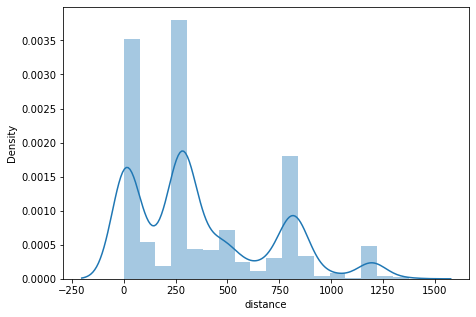

3024
372.43997388766275
334.324367241932
1373.7018027613362
Highest allowed 1375.4130756134587
Lowest allowed -630.5331278381333


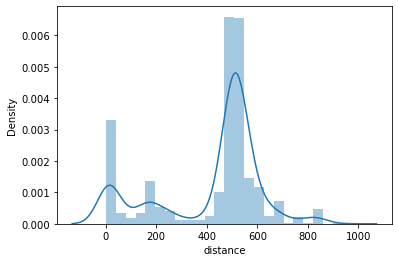

2250
420.5930569847473
209.08387529748708
938.008886850106
Highest allowed 1047.8446828772085
Lowest allowed -206.6585689077139


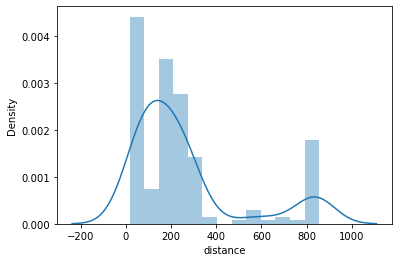

207
255.01344876899847
246.37056520256507
855.2562887218606
Highest allowed 994.1251443766937
Lowest allowed -484.0982468386967


In [118]:
# 1b. remove outlier using z score and then map each POI to a scale that ranges from -10 to 10
# Using z score may not be a good idea because the data is not normally distributed!!!!
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
for index,row in pols.iterrows():
    df2 = df[df.label == row["POIID"]]
    data = df2["distance"]
    # filterd out outliers
    upperBound = data.mean() + 3*data.std()
    lowerBound = data.mean() - 3*data.std()
    data = data.loc[(data > lowerBound) & (data < upperBound)]
    # repeat last step
    upperBound = data.mean() + 3*data.std()
    lowerBound = data.mean() - 3*data.std()
    data = data.loc[(data > lowerBound) & (data < upperBound)]
    # final filter and no more outliers detected 
    upperBound = data.mean() + 3*data.std()
    lowerBound = data.mean() - 3*data.std()
    data = data.loc[(data > lowerBound) & (data < upperBound)]
    
    # update pols df
    pols.loc[index, "Average"] =  data.mean() 
    pols.loc[index, "StandardDeviation"] = data.std()
    pols.loc[index, "radius"] =data.max() 
    pols.loc[index, "count"] =data.count() 
    r = data.max() 
    pols.loc[index, "density"] =data.count()/(math.pi*(r**2))
    sns.distplot(data)
    #sns.boxplot(data)
    plt.show()
    print(data.count())
    print(data.mean())
    print(data.std())
    print(data.max())
    print("Highest allowed",data.mean() + 3*data.std())
    print("Lowest allowed",data.mean() - 3*data.std())
# calculate popularity    
for index,row in pols.iterrows():
    pols.loc[index, "popularity"] =  ((row.density - pols.density.min())/(pols.density.max()-pols.density.min()))*20-10



In [119]:
pols


,POIID,Latitude,Longitude,Average,StandardDeviation,radius,count,density,popularity
1,POI1/POI2,53.546167,-113.485734,372.439974,334.324367,1373.701803,3024.0,0.000510,1.603945
2,POI3,45.521629,-73.566024,420.593057,209.083875,938.008887,2250.0,0.000814,10.000000
3,POI4,45.224830,-63.232729,255.013449,246.370565,855.256289,207.0,0.000090,-10.000000


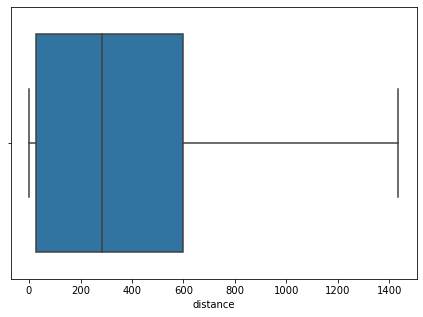

3027
373.458734297509
335.72168927172004
1433.9069160807276
Highest allowed 1451.3510865039366
Lowest allowed -828.7786935460055


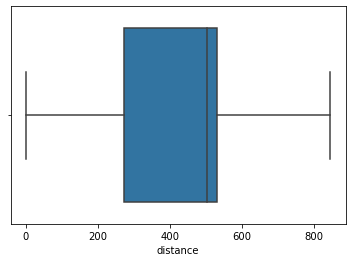

2249
420.36299214265506
208.84532185435347
845.67503658165
Highest allowed 914.6033691406781
Lowest allowed -110.5078399524561


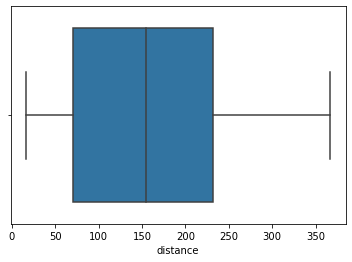

174
155.15555253693316
85.18509524858526
367.0262287390333
Highest allowed 499.97495675556513
Lowest allowed -187.4080374546766


In [120]:
# 1c. remove outlier using IQR  and then map each POI to a scale that ranges from -10 to 10
# This method is better than using z score because the data distribution is skewed
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
for index,row in pols.iterrows():

    
    df2 = df[df.label == row["POIID"]]
    data = df2["distance"]
    
    percentile25 = data.quantile(0.25)
    percentile75 = data.quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    data = data.loc[(data > lower_limit) & (data < upper_limit)]
    
    percentile25 = data.quantile(0.25)
    percentile75 = data.quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    data = data.loc[(data > lower_limit) & (data < upper_limit)]

    percentile25 = data.quantile(0.25)
    percentile75 = data.quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    data = data.loc[(data > lower_limit) & (data < upper_limit)]
    
    # update pols df
    pols.loc[index, "Average"] =  data.mean() 
    pols.loc[index, "StandardDeviation"] = data.std()
    pols.loc[index, "radius"] =data.max() 
    r = data.max() 
    pols.loc[index, "density"] =data.count()/(math.pi*(r**2))
    pols.loc[index, "count"] =data.count() 
    #sns.distplot(data)
    sns.boxplot(data)
    plt.show()
    print(data.count())
    print(data.mean())
    print(data.std())
    print(data.max())
    print("Highest allowed",upper_limit)
    print("Lowest allowed",lower_limit)
# calculate popularity   
for index,row in pols.iterrows():
    pols.loc[index, "popularity"] =  ((row.density - pols.density.min())/(pols.density.max()-pols.density.min()))*20-10



In [121]:
pols

,POIID,Latitude,Longitude,Average,StandardDeviation,radius,count,density,popularity
1,POI1/POI2,53.546167,-113.485734,373.458734,335.721689,1433.906916,3027.0,0.000469,-8.051506
2,POI3,45.521629,-73.566024,420.362992,208.845322,845.675037,2249.0,0.001001,10.000000
3,POI4,45.224830,-63.232729,155.155553,85.185095,367.026229,174.0,0.000411,-10.000000


In [122]:
# 4.2



In [ ]:
# relationship between (Latitude, Longitude) and count
from sklearn import linear_model
X = pols[['Latitude', 'Longitude']]
y = pols['count']

regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")


In [ ]:
# relationship between (Latitude, Longitude) and radius
from sklearn import linear_model
X = pols[['Latitude', 'Longitude']]
y = pols['radius']


regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")

In [ ]:
# relationship between (Latitude, Longitude) and density
from sklearn import linear_model
X = pols[['Latitude', 'Longitude']]
y = pols['density']

regr = linear_model.LinearRegression()
regr.fit(X, y)
r_sq = regr.score(X, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")

In [ ]:
# Distribution of province for each poi is shown below

In [123]:
province = df.filter(['Province'])
province.drop_duplicates(inplace = True)
province


,Province
0,ON
172,SK
179,AB
194,QC
238,BC
284,NB
403,NS
815,MB
1162,NL
4627,YT


In [124]:
# raw data
for index,row in province.iterrows():
    province.loc[index, 'count'] =  df[df.Province == row['Province']]['Province'].count() 
province

,Province,count
0,ON,1869.0
172,SK,274.0
179,AB,2041.0
194,QC,460.0
238,BC,549.0
284,NB,82.0
403,NS,90.0
815,MB,148.0
1162,NL,31.0
4627,YT,2.0


In [125]:
# data for poi1/poi2
poi12 = df[df.label == 'POI1/POI2']
for index,row in province.iterrows():
    province.loc[index, 'count'] =  poi12[poi12.Province == row['Province']]['Province'].count()
province

,Province,count
0,ON,20.0
172,SK,274.0
179,AB,2041.0
194,QC,5.0
238,BC,549.0
284,NB,0.0
403,NS,0.0
815,MB,148.0
1162,NL,0.0
4627,YT,2.0


In [126]:
# data for poi3
poi3 = df[df.label == 'POI3']
for index,row in province.iterrows():
    province.loc[index, 'count'] =  poi3[poi3.Province == row['Province']]['Province'].count()
province

,Province,count
0,ON,1838.0
172,SK,0.0
179,AB,0.0
194,QC,451.0
238,BC,0.0
284,NB,0.0
403,NS,0.0
815,MB,0.0
1162,NL,0.0
4627,YT,0.0


In [127]:
# data for poi4
poi4 = df[df.label == 'POI4']
for index,row in province.iterrows():
    province.loc[index, 'count'] =  poi4[poi4.Province == row['Province']]['Province'].count()
province

,Province,count
0,ON,11.0
172,SK,0.0
179,AB,0.0
194,QC,4.0
238,BC,0.0
284,NB,82.0
403,NS,90.0
815,MB,0.0
1162,NL,31.0
4627,YT,0.0
